In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import os
from astropy.io import fits
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import light_curve as lc
plt.style.use('seaborn-whitegrid')

In [2]:
# main dataframe with all info
df = pd.read_csv('data/gbmdatacleaned.csv', index_col=0)

In [3]:
# dataframe with reference and target GRB info
newdf = pd.read_csv('data/distance_dat_file.csv')

In [4]:
def get_subset_df(fulldf, sub_df):
    ref_rows = []
    ref_idx = []
    for i in range(sub_df.shape[0]):
        x = sub_df.iloc[i].name
        df1 = fulldf[:x]
        ref_row = df1[df1['Is Reference'] == 1].iloc[-1]
        if ref_row.Index not in ref_idx:
            ref_rows.append(ref_row)
            ref_idx.append(ref_row.Index)
    df2 = pd.DataFrame(ref_rows)
    return pd.concat([sub_df, df2], sort=False).sort_index()

In [5]:
def get_dict_from_df(df):
    dct = dict()
    isref = df['Is Reference'].values
    idx = df['Index'].values
    for i, (x,y) in enumerate(zip(isref, idx)):
        if x:
            i += 1
            ls = []
            while i < len(isref) and isref[i] == 0:
                ls.append(idx[i])
                i += 1
            dct[y] = ls
    
    return dct

In [6]:
def get_fit_file(name):
    d = newdf.loc[newdf['Name'] == name]['Brightest Detector'].values[0]
    # try suffix _v01 or _v00
    dig = 0
    path = ''
    while not os.path.exists(path):
        path = 'C:/Users/hhsud/Downloads/GRBS/glg_tte_' + d + '_bn' + name[3:] + '_v0' + str(dig) + '.fit'
        dig += 1
        if dig > 100:
            print(path)
            raise FileNotFoundError

    return fits.open(path)

In [7]:
sub_df1 = newdf.loc[newdf.Sigma < 0.5, :]
grbdf = get_subset_df(newdf, sub_df1)

In [8]:
dct = get_dict_from_df(grbdf)

In [9]:
delays = []
for i, (key, value) in enumerate(dct.items()):
    ref_time = datetime.strptime(df.trigger_time.iloc[key], '%Y-%m-%d %H:%M:%S.%f')
    delays.append(None)
    for x in value:
        tar_time = datetime.strptime(df.trigger_time.iloc[x], '%Y-%m-%d %H:%M:%S.%f')
        delay = abs(ref_time - tar_time)
        delays.append(delay)

In [10]:
grbdf['Delay'] = delays

### Plots of light curve with $\sigma < 3$
Legend : <br>
Blue = Reference <br>
Green = Target

In [23]:
def make_hist(ref, ref_name, tar, tar_name, info_tuple):
    df_ref = lc.df_from_fit_file(ref)
    df_tar = lc.df_from_fit_file(tar)
    t90_ref = lc.get_t90(ref_name)
    t90_tar = lc.get_t90(tar_name)
    start1 = -10
    end1 = max(t90_ref, t90_tar) + 10
    size1 = 0.1 if t90_ref < 2 else 1
    size2 = 0.1 if t90_tar < 2 else 1
    
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
    fig.suptitle(f'Distance : {info_tuple[0]}, Sigma : {info_tuple[1]}, Delay : {info_tuple[2]}', fontsize=16)
    ref = axs[0].hist(df_ref.TTIME, bins=int((end1 - start1)/size1), range=(start1,end1),
                label = ref_name, histtype='step', color='b')
    tar = axs[1].hist(df_tar.TTIME, bins=int((end1 - start1)/size2), range=(start1,end1),
                label = tar_name, histtype='step', color='g')
    
    ref[2][0].set_xy(ref[2][0].get_xy()[1:])
    tar[2][0].set_xy(tar[2][0].get_xy()[1:])
    ref[2][0].set_xy(ref[2][0].get_xy()[:-1])
    tar[2][0].set_xy(tar[2][0].get_xy()[:-1])
    
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0)
    fig.legend(bbox_to_anchor=(0.9,0.2), borderaxespad=0, labels=[ref_name, tar_name], loc='center right')

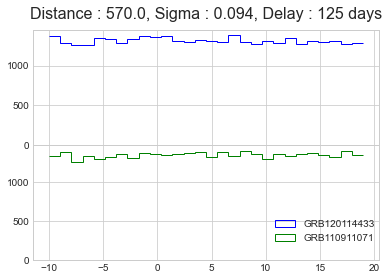

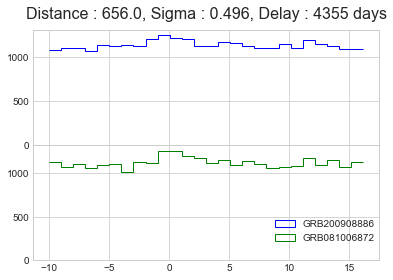

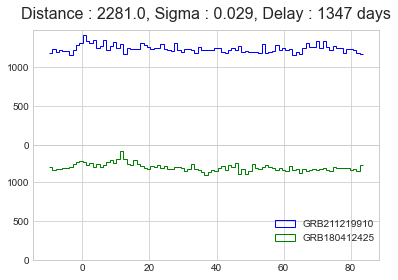

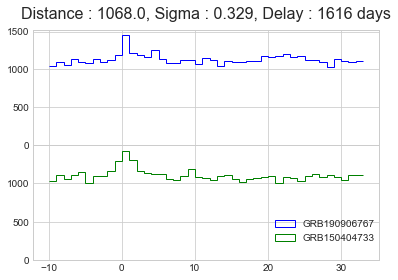

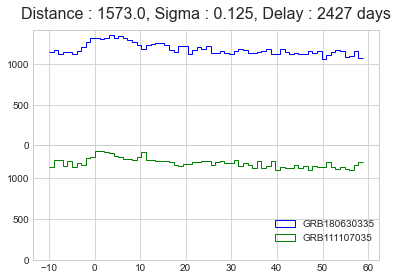

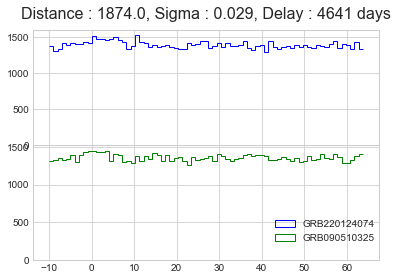

In [24]:
for i, (key, value) in enumerate(dct.items()):
    ref_name = grbdf[grbdf.Index == key]['Name'].values[0]
    ref = get_fit_file(ref_name)
    for x in value:
        tar_name = grbdf[grbdf.Index == x]['Name'].values[0]
        tar = get_fit_file(tar_name)
        row = grbdf.loc[grbdf.Index == x]
        info_tuple = (row.Distance.values[0], row.Sigma.values[0], 
                    row.Delay.values[0].astype("timedelta64[D]"))
        make_hist(ref, ref_name, tar, tar_name, info_tuple)

### Time delay vs $\sigma$

In [25]:
sub_df2 = grbdf.loc[grbdf.Sigma < 0.5, :]
df1 = get_subset_df(newdf, sub_df2) 

In [26]:
df1['Delay_day'] = df1.Delay.apply(lambda x : x.total_seconds() / (3600 * 24))

In [27]:
fig = px.scatter(df1, x='Delay_day', y=df1['Sigma'], labels={'Delay_day':'Days'})
fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 250
    ),
    yaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 0.25
    )
)
fig.show()

### T90 ref vs T90 target

In [28]:
t90x = []
t90y = []
t90x_err = []
t90y_err = []
sigma_less_1 = []
for key, value in dct.items():
    a = grbdf.loc[grbdf.Index == key].t90.values[0]
    errx = float(df.iloc[key].t90_error)
    for x in value:
        row = grbdf.loc[grbdf.Index==x]
        b = row.t90.values[0]
        t90x.append(a)
        t90y.append(b)
        t90x_err.append(errx)
        t90y_err.append(float(df.iloc[x].t90_error))
        sigma_less_1.append(row.Sigma.values[0] < 1)

In [29]:
plotdf_t90 = pd.DataFrame({'x':t90x, 'y':t90y, 'sigma_less_1':sigma_less_1})

In [30]:
plotdf_t90['logx'] = np.log(plotdf_t90.x)
plotdf_t90['logy'] = np.log(plotdf_t90.y)

In [31]:
import numpy as np

In [32]:
# import statsmodels.api as sm
# from statsmodels.formula.api import ols
# from scipy.stats import norm
# #fit simple linear regression model
# model = ols('y ~ x', data=plotdf_t90).fit()
# res = model.resid.values
# plt.hist(res)
# mu, std = norm.fit(res)
# xmin, xmax = plt.xlim()
# x = np.linspace(xmin, xmax, 100)
# p = norm.pdf(x, mu, std)
# plt.plot(x, p, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
# plt.title(title)
# plt.show()

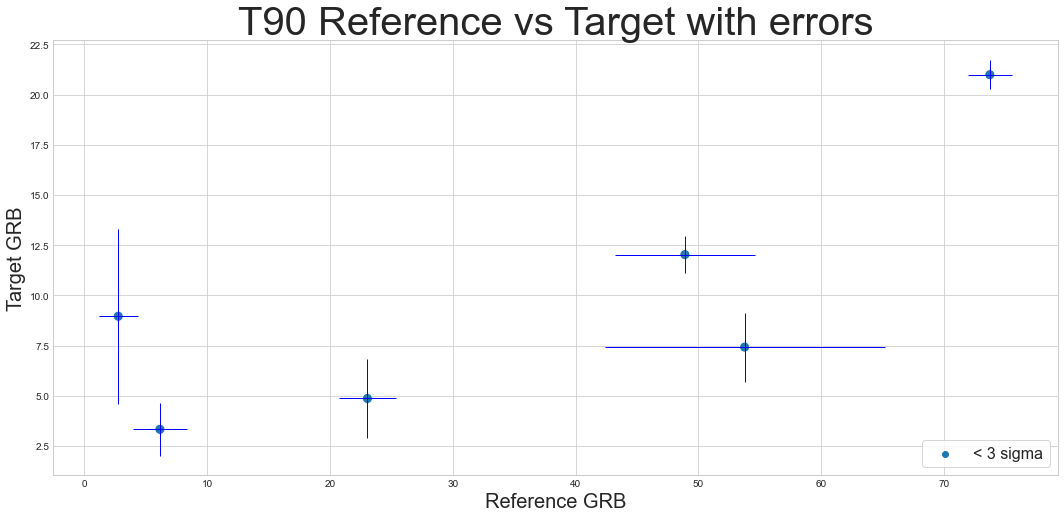

In [33]:
sns.set_style("whitegrid")
plt.figure(figsize=(18,8))
ax = sns.scatterplot(data=plotdf_t90, x='x', y='y', hue='sigma_less_1', s=100)
# m, b = np.polyfit(plotdf_t90.x, plotdf_t90.y, 1)
# sns.lineplot(x=plotdf_t90.x, y=m*plotdf_t90.x + b, color='g')
plt.errorbar(plotdf_t90.x, plotdf_t90.y, xerr=t90x_err, yerr=t90y_err, fmt='none', ecolor='b', linewidth=1)
handles, labels  =  ax.get_legend_handles_labels()
ax.set_title('T90 Reference vs Target with errors',fontsize=40)
ax.set_ylabel('Target GRB', fontsize=20)
ax.set_xlabel('Reference GRB', fontsize=20)
ax.legend(handles, ['< 3 sigma', '< 1 sigma'], loc='lower right', frameon=True, fontsize=16)

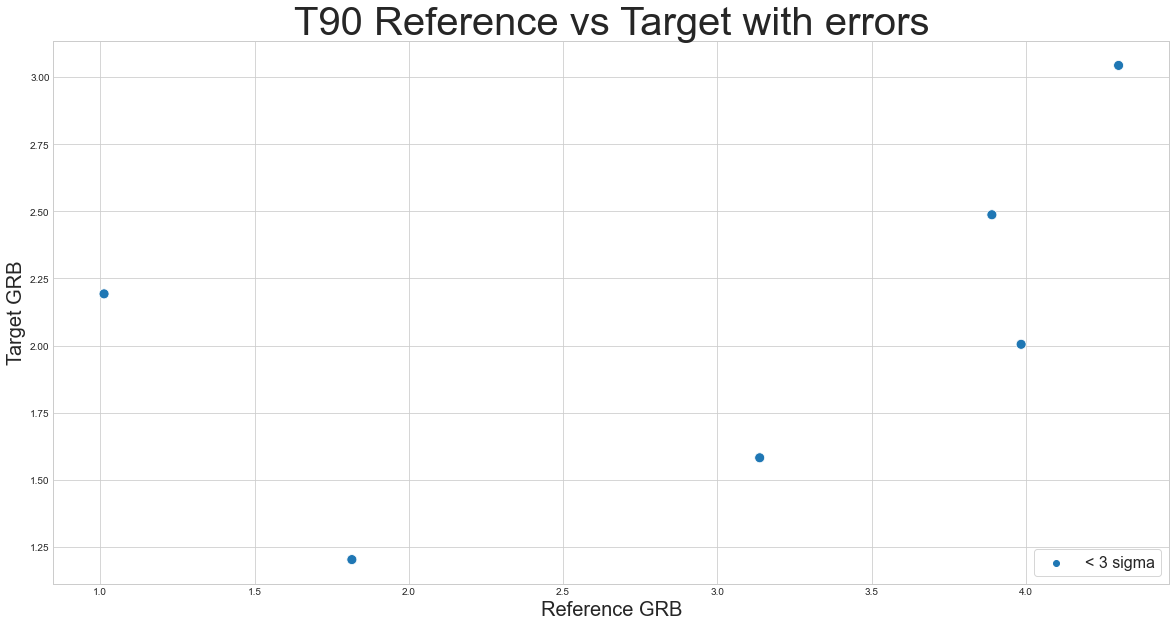

In [34]:
sns.set_style("whitegrid")
plt.figure(figsize=(20,10))
ax = sns.scatterplot(data=plotdf_t90, x='logx', y='logy', hue='sigma_less_1', s=100)
# m, b = np.polyfit(plotdf_t90.x, plotdf_t90.y, 1)
# sns.lineplot(x=plotdf_t90.x, y=m*plotdf_t90.x + b, color='g')
# plt.errorbar(plotdf_t90.logx, plotdf_t90.logy, xerr=np.log(np.array(t90x_err)), yerr=np.log(np.array(t90y_err)), fmt='none', ecolor='b', linewidth=1)
handles, labels  =  ax.get_legend_handles_labels()
ax.set_title('T90 Reference vs Target with errors',fontsize=40)
ax.set_ylabel('Target GRB', fontsize=20)
ax.set_xlabel('Reference GRB', fontsize=20)
ax.legend(handles, ['< 3 sigma', '< 1 sigma'], loc='lower right', frameon=True, fontsize=16)

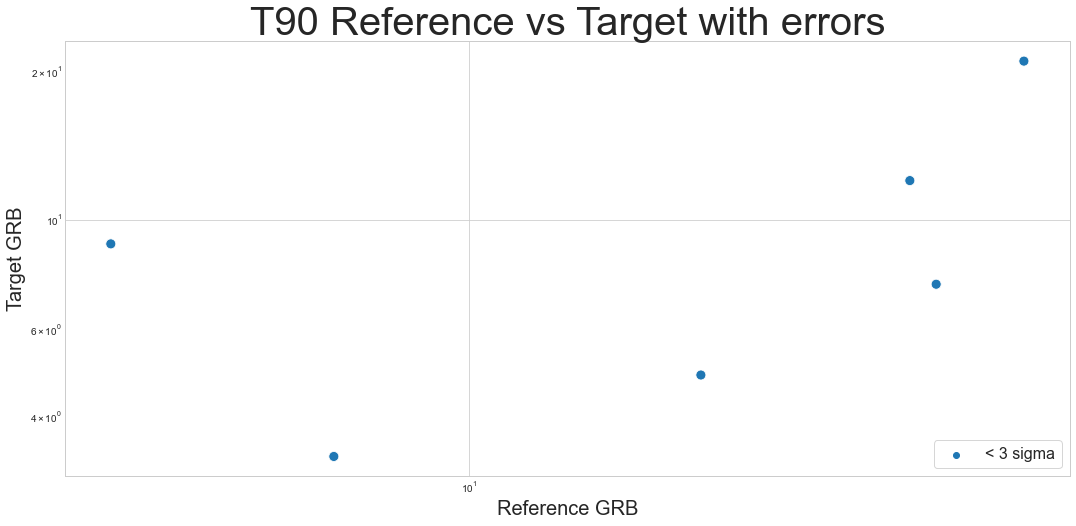

In [35]:
sns.set_style("whitegrid")
plt.figure(figsize=(18,8))
ax = sns.scatterplot(data=plotdf_t90, x='x', y='y', hue='sigma_less_1', s=100)
# m, b = np.polyfit(plotdf_t90.x, plotdf_t90.y, 1)
# sns.lineplot(x=plotdf_t90.x, y=m*plotdf_t90.x + b, color='g')
# plt.scatter(plotdf_t90.x, plotdf_t90.y)
# plt.errorbar(plotdf_t90.x, plotdf_t90.y, xerr=t90x_err, yerr=t90y_err, fmt='none', ecolor='b', linewidth=1)
# plt.xscale('log')
# plt.yscale('log')
handles, labels  =  ax.get_legend_handles_labels()
ax.set_title('T90 Reference vs Target with errors',fontsize=40)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Target GRB', fontsize=20)
ax.set_xlabel('Reference GRB', fontsize=20)
ax.legend(handles, ['< 3 sigma', '< 1 sigma'], loc='lower right', frameon=True, fontsize=16)

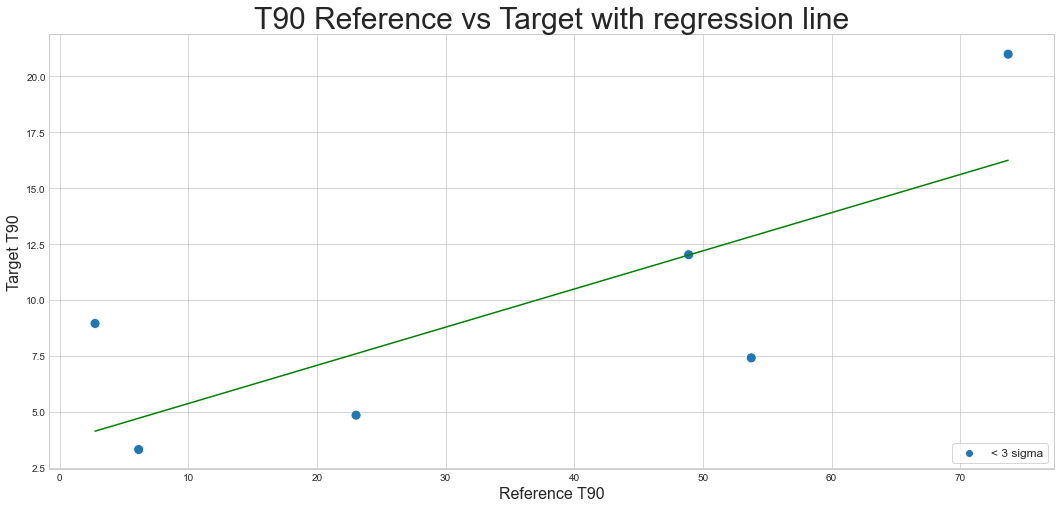

In [36]:
sns.set_style("whitegrid")
plt.figure(figsize=(18,8))
ax = sns.scatterplot(data=plotdf_t90, x='x', y='y', hue='sigma_less_1', s=100)
m, b = np.polyfit(plotdf_t90.x, plotdf_t90.y, 1)
sns.lineplot(x=plotdf_t90.x, y=m*plotdf_t90.x + b, color='g')
# plt.errorbar(plotdf_t90.x, plotdf_t90.y, xerr=t90x_err, yerr=t90y_err, fmt='none', ecolor='b', linewidth=1)
handles, labels  =  ax.get_legend_handles_labels()
ax.set_title('T90 Reference vs Target with regression line',fontsize=30)
ax.set_ylabel('Target T90', fontsize=16)
ax.set_xlabel('Reference T90', fontsize=16)
ax.legend(handles, ['< 3 sigma', '< 1 sigma'], loc='lower right', frameon=True, fontsize=12)

### Fluence ref vs Fluence target

In [37]:
fluencex = []
fluencey = []
sigma_less_1 = []
for key, value in dct.items():
    a = df.iloc[key].fluence
    for x in value:
        row = grbdf.loc[grbdf.Index == x]
        b = df.iloc[x].fluence
        fluencex.append(a)
        fluencey.append(b)
        sigma_less_1.append(row.Sigma.values[0] < 1)

In [38]:
fluencex = [float(x) for x in fluencex]
fluencey = [float(x) for x in fluencey]

In [39]:
plotdf_fluence = pd.DataFrame({'x':fluencex, 'y':fluencey, 'sigma_less_1':sigma_less_1})

In [40]:
plotdf_fluence['logx'] = np.log(plotdf_fluence.x)
plotdf_fluence['logy'] = np.log(plotdf_fluence.y)

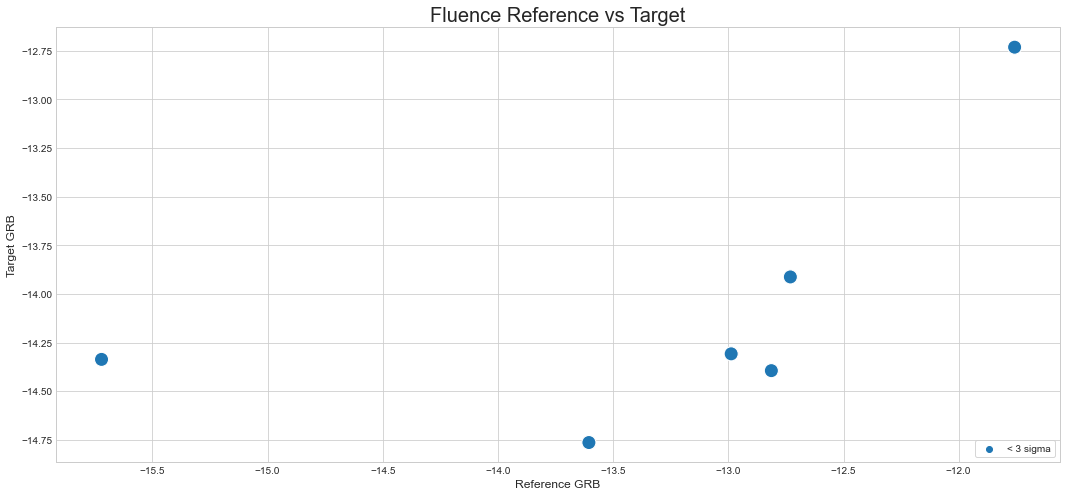

In [41]:
plt.figure(figsize=(18,8))
ax = sns.scatterplot(data=plotdf_fluence, x='logx', y='logy', hue='sigma_less_1', s=200)
handles, labels  =  ax.get_legend_handles_labels()
ax.set_title('Fluence Reference vs Target',fontsize=20)
ax.set_ylabel('Target GRB', fontsize=12)
ax.set_xlabel('Reference GRB', fontsize=12)
ax.legend(handles, ['< 3 sigma', '< 1 sigma'], loc='lower right', frameon=True)

### Distribution of delays

In [43]:
sub_df3 = grbdf.loc[grbdf.Sigma < 0.5, :]
df2 = get_subset_df(newdf, sub_df3) 

In [44]:
df2['Delay_day'] = df2.Delay.apply(lambda x : x.total_seconds() / (3600 * 24))

In [45]:
delay_days = [x for x in df2.Delay_day if not np.isnan(x)]

Text(0.5, 1.0, 'Delay Days Distribution, sigma < 1')

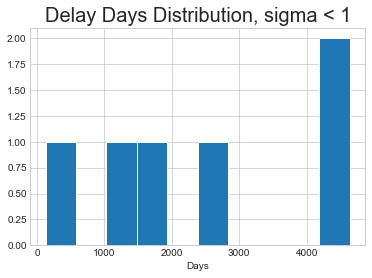

In [46]:
plt.hist(delay_days)
plt.xlabel('Days')
plt.title('Delay Days Distribution, sigma < 1', fontsize=20)

In [47]:
grbdf['Delay_day'] = grbdf.Delay.apply(lambda x : x.total_seconds() / (3600 * 24))

In [48]:
delay_days = [x for x in grbdf.Delay_day if not np.isnan(x)]

Text(0.5, 1.0, 'Delay Days Distribution, sigma < 3')

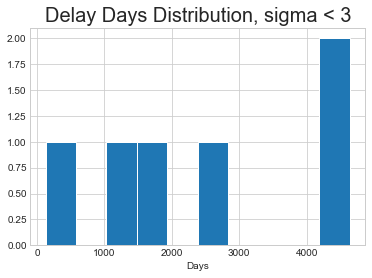

In [49]:
plt.hist(delay_days)
plt.xlabel('Days')
plt.title('Delay Days Distribution, sigma < 3', fontsize=20)